#Download Dataset into Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import os
import kagglehub
import shutil

# Define the paths for the new directories
datasets_folder_path = '/content/drive/My Drive/Datasets'
skin_cancer_folder_path = os.path.join(datasets_folder_path, 'Skin-Cancer-BinaryClass')

# Create the directories
os.makedirs(skin_cancer_folder_path, exist_ok=True)

# Download latest version
path = kagglehub.dataset_download("rm1000/skin-cancer-isic-images")

print("Path to dataset files:", path)

# Move the downloaded files to the 'brain tumor dataset' folder
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(skin_cancer_folder_path, filename))

print("Dataset files downloaded to:", skin_cancer_folder_path)


100%|██████████| 50.6M/50.6M [00:03<00:00, 15.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/skin-cancer-isic-images/versions/1
Dataset files downloaded to: /content/drive/My Drive/Datasets/Skin-Cancer-BinaryClass


#Import Libraries

In [2]:
! pip install torchviz
! pip install split-folders
! pip install torchsummary
! pip install imblearn

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=ef078c27041e3b6ff66ceeacebe720d7e2803fd337161a9e92a4b3bf1ea937bb
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim
import torchvision.models as models
from torchviz import make_dot
from torchvision import models
from torchviz import make_dot
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#import zipfile

#Data analitycs and Visualization

In [4]:
import os

# Define the path to the directories
malignant_dir = '/content/drive/MyDrive/Datasets/Skin-Cancer-BinaryClass/malignant/'
benign_dir = '/content/drive/MyDrive/Datasets/Skin-Cancer-BinaryClass/benign/'

# List all files in the malignant directory
malignant_files = [f for f in os.listdir(malignant_dir) if os.path.isfile(os.path.join(malignant_dir, f))]
benign_files = [f for f in os.listdir(benign_dir) if os.path.isfile(os.path.join(benign_dir, f))]

# Print out the first few files to verify
print("Malignant files:", malignant_files[:5])
print("Benign files:", benign_files[:5])


Malignant files: ['0743.jpg', '0759.jpg', '0911.jpg', '0098.jpg', '0657.jpg']
Benign files: ['0274.jpg', '1000.jpg', '0870.jpg', '0271.jpg', '1722.jpg']


In [5]:
# Create a DataFrame with the correct paths
malignant_paths = [os.path.join(malignant_dir, f) for f in malignant_files]
benign_paths = [os.path.join(benign_dir, f) for f in benign_files]

# Create labels
malignant_labels = ['malignant'] * len(malignant_paths)
benign_labels = ['benign'] * len(benign_paths)

# Combine into a DataFrame
data = malignant_paths + benign_paths
labels = malignant_labels + benign_labels

df = pd.DataFrame({'image_path': data, 'label': labels})

# Check the DataFrame
print(df.head())


                                          image_path      label
0  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
1  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
2  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
3  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
4  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant


In [8]:
dataset_copy = copy.deepcopy(df)

In [9]:
df.shape

(3297, 2)

In [10]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [11]:
#df.duplicated(): This method checks for duplicate rows in the DataFrame df. It returns a boolean Series where True indicates that a row is a duplicate of a previous row.
df.duplicated().sum()

0

In [12]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [13]:
df['label'].unique()

array(['malignant', 'benign'], dtype=object)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297 entries, 0 to 3296
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3297 non-null   object
 1   label       3297 non-null   object
dtypes: object(2)
memory usage: 51.6+ KB


In [15]:
df.describe()

image_path   label
count                                                3297    3297
unique                                               3297       2
top     /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  benign
freq                                                    1    1800

In [16]:
label_counts = df['label'].value_counts()

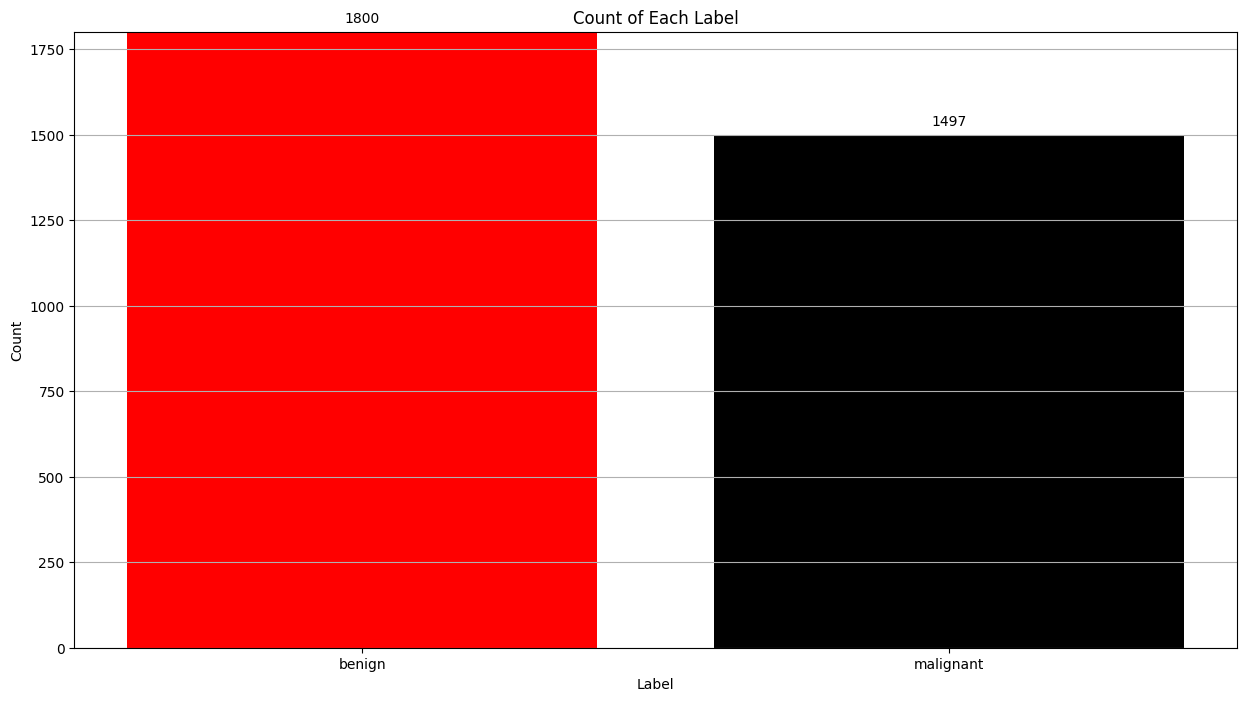

In [17]:
# Define a color for each label
colors = {
    'benign': 'red',
    'malignant': 'black'
}

# Create the plot
plt.figure(figsize=(15, 8))
bars = plt.bar(label_counts.index, label_counts.values, color=[colors[label] for label in label_counts.index])

# Set y-axis limit
plt.ylim(0, label_counts.max() + 1)

# Annotate bars with their heights
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # Offset text slightly above the bar
                 textcoords='offset points',
                 ha='center',
                 va='bottom')

# Show the plot
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.grid(axis='y')
plt.show()


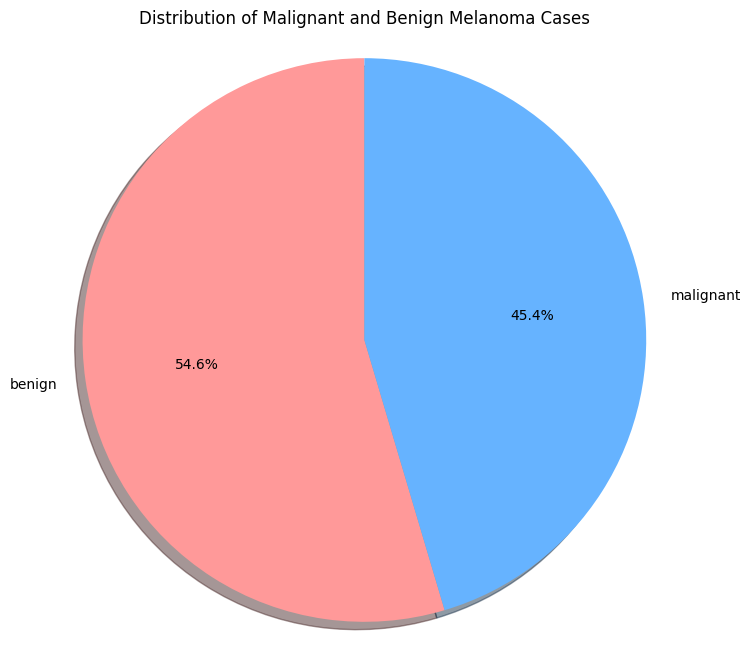

In [18]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts,
        labels=label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff'],  # Specify colors for each label
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of Malignant and Benign Melanoma Cases')
plt.show()


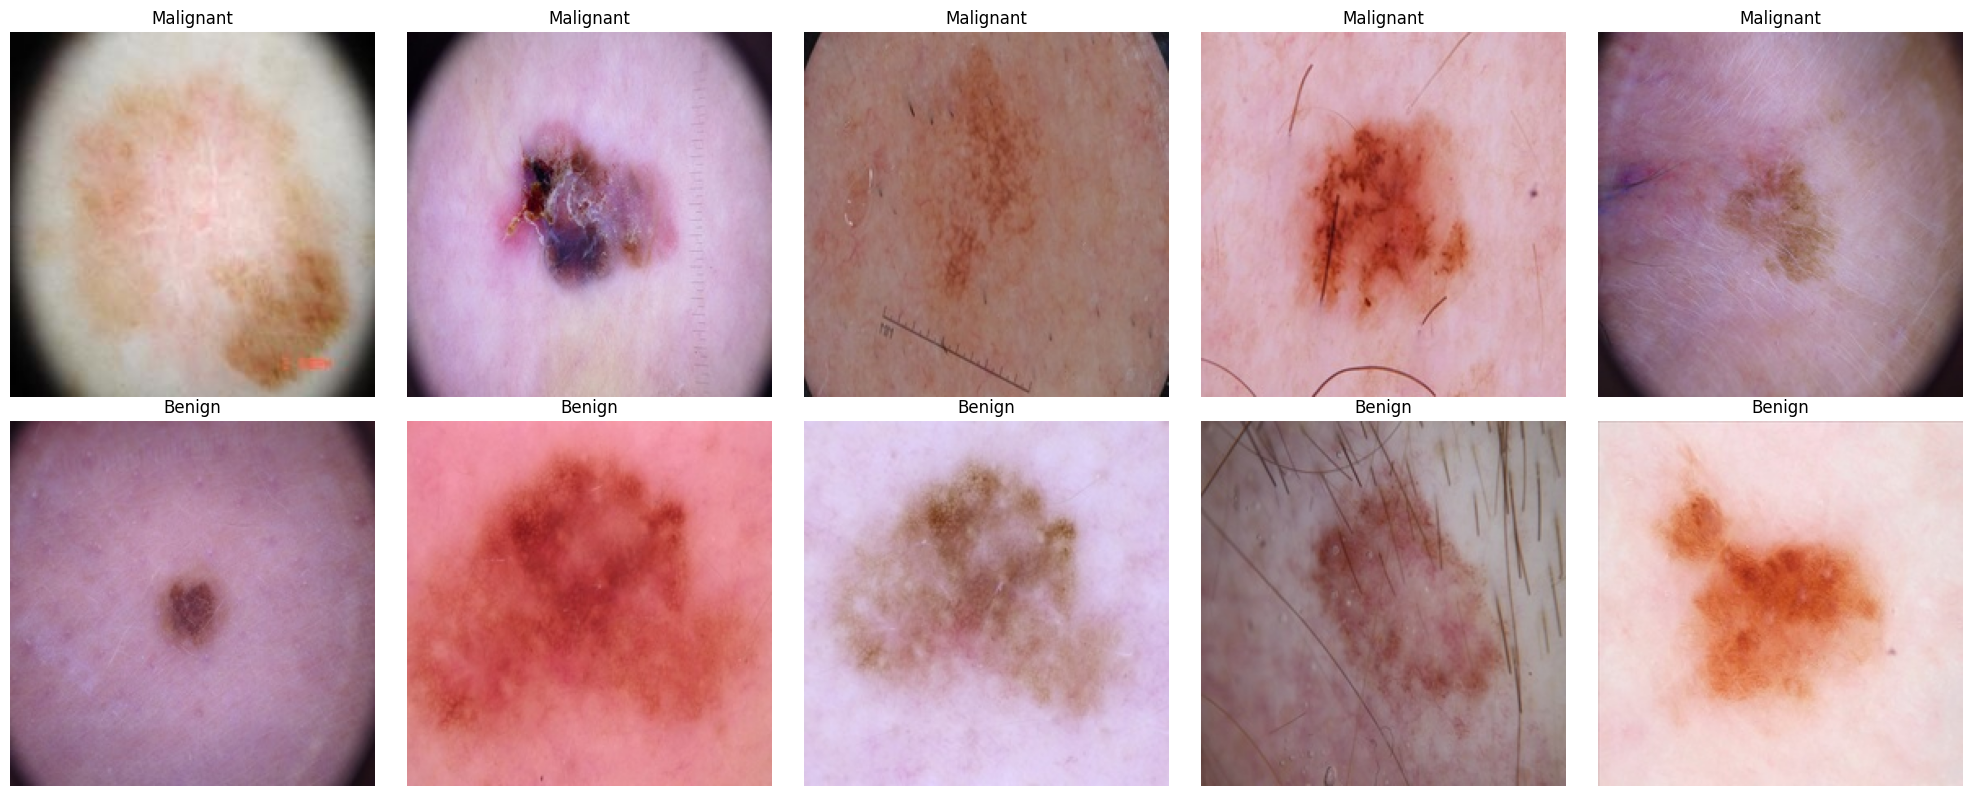

In [19]:
# List images in each directory
malignant_images = os.listdir(malignant_dir)
benign_images = os.listdir(benign_dir)

# Randomly sample 5 images from each category
malignant_sample = np.random.choice(malignant_images, 5, replace=False)
benign_sample = np.random.choice(benign_images, 5, replace=False)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Display malignant images
for ax, img_name in zip(axes[0], malignant_sample):
    img_path = os.path.join(malignant_dir, img_name)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Malignant')

# Display benign images
for ax, img_name in zip(axes[1], benign_sample):
    img_path = os.path.join(benign_dir, img_name)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Benign')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']],
df['label'])
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['label'] = y_resampled
print("\nClass distribution after oversampling:")
print(df_resampled['label'].value_counts())


Class distribution after oversampling:
label
malignant    1800
benign       1800
Name: count, dtype: int64


In [21]:
label_counts = df_resampled['label'].value_counts()

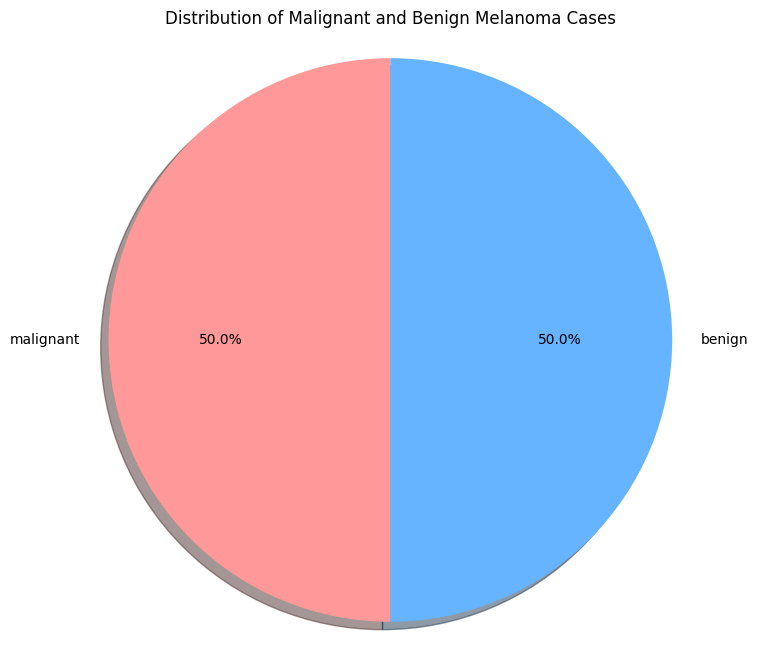

In [22]:
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts,
        labels=label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff'],  # Specify colors for each label
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of Malignant and Benign Melanoma Cases')
plt.show()


In [23]:
df_resampled

image_path      label
0     /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
1     /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
2     /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
3     /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
4     /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
...                                                 ...        ...
3595  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
3596  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
3597  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
3598  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant
3599  /content/drive/MyDrive/Datasets/Skin-Cancer-Bi...  malignant

[3600 rows x 2 columns]

#Import And Transform Dataset

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Step 2: Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip images vertically
    transforms.RandomRotation(degrees=30),  # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])


class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = dataframe['label'].unique()  # Store unique class names
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.classes)  # Fit the label encoder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Get image path
        label = self.dataframe.iloc[idx, 1]  # Get label

        # Check if the path is a file
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")

        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB

        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Convert label to integer and then to tensor
        label = self.label_encoder.transform([label])[0]  # Transform the label to an integer
        label = torch.tensor(label, dtype=torch.long)  # Convert to tensor

        return img, label


# Step 4: Load the dataset from the DataFrame
dataset = CustomDataset(df_resampled, transform=transform)

# Step 5: Get the indices for splitting and the labels for stratification
indices = list(range(len(dataset)))
labels = df_resampled['label'].values  # Extract labels for stratification

# Step 6: Split the data into training and temporary sets (80% train, 20% temp)
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)

# Step 7: Further split the temporary set into validation and test sets (50% each of the temp set)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, stratify=labels[temp_indices])

# Step 8: Create training, validation, and testing subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Step 9: Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [27]:
print(dataset)

In [28]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

In [29]:
print(train_loader)
print(val_loader)
print(test_loader)

In [30]:
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Testing dataset size:", len(test_dataset))

Training dataset size: 2880
Validation dataset size: 360
Testing dataset size: 360


In [31]:
print("Training dataset size:", len(train_loader))
print("Validation dataset size:", len(val_loader))
print("Testing dataset size:", len(test_loader))

Training dataset size: 90
Validation dataset size: 12
Testing dataset size: 12


#Visualize data fram each class

tensor(1)


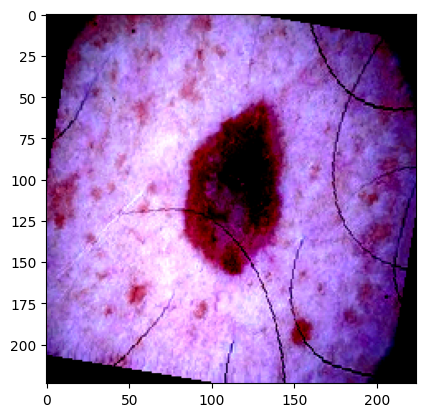

In [32]:
img, label = train_dataset[328]
plt.imshow(img.permute(1,2,0)) #convert into bgr format
print(label)

#Create Custom CNN Neural Network with Torch

In [69]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()

        # Convolutional layers with increased kernel size
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization after conv1

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after conv2

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after conv3

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5

        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)  # Batch normalization after conv5

        # Max pooling layers
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Activation Function
        self.leakyRelu = nn.LeakyReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 3 * 3, 512)  # Adjusted input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # Convolutional layers with max pooling, batch normalization, and dropout
        x = self.leakyRelu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn4(self.conv4(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn5(self.conv5(x)))
        x = self.maxpool(x)

        x = self.leakyRelu(self.bn6(self.conv6(x)))
        x = self.maxpool(x)


        # Flatten
        out = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        out = self.leakyRelu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)


        return out


In [70]:
Model = CNNmodel()

#check Cuda and connect to it

In [71]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    # Get the current device
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device: {current_device}")

    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")


CUDA is available!
Current CUDA device: 0
Number of available GPUs: 1
GPU 0: Tesla T4


In [72]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the appropriate device
Model.to(device)

# Create a dummy input tensor on the same device
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# Print model summary
summary(Model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         LeakyReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
         LeakyReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
        LeakyReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

#Visualize Model Arcitecture

In [73]:
# Create a dummy input
x = torch.randn(1, 3, 224, 224).to(device)  # Batch size of 1

# Get the output
y = Model(x)

# Visualize the model
dot = make_dot(y, params=dict(list(Model.named_parameters())))
dot.render("cnn_architecture3 for skincancer", format="png")  # Save as PNG


'cnn_architecture3 for skincancer.png'

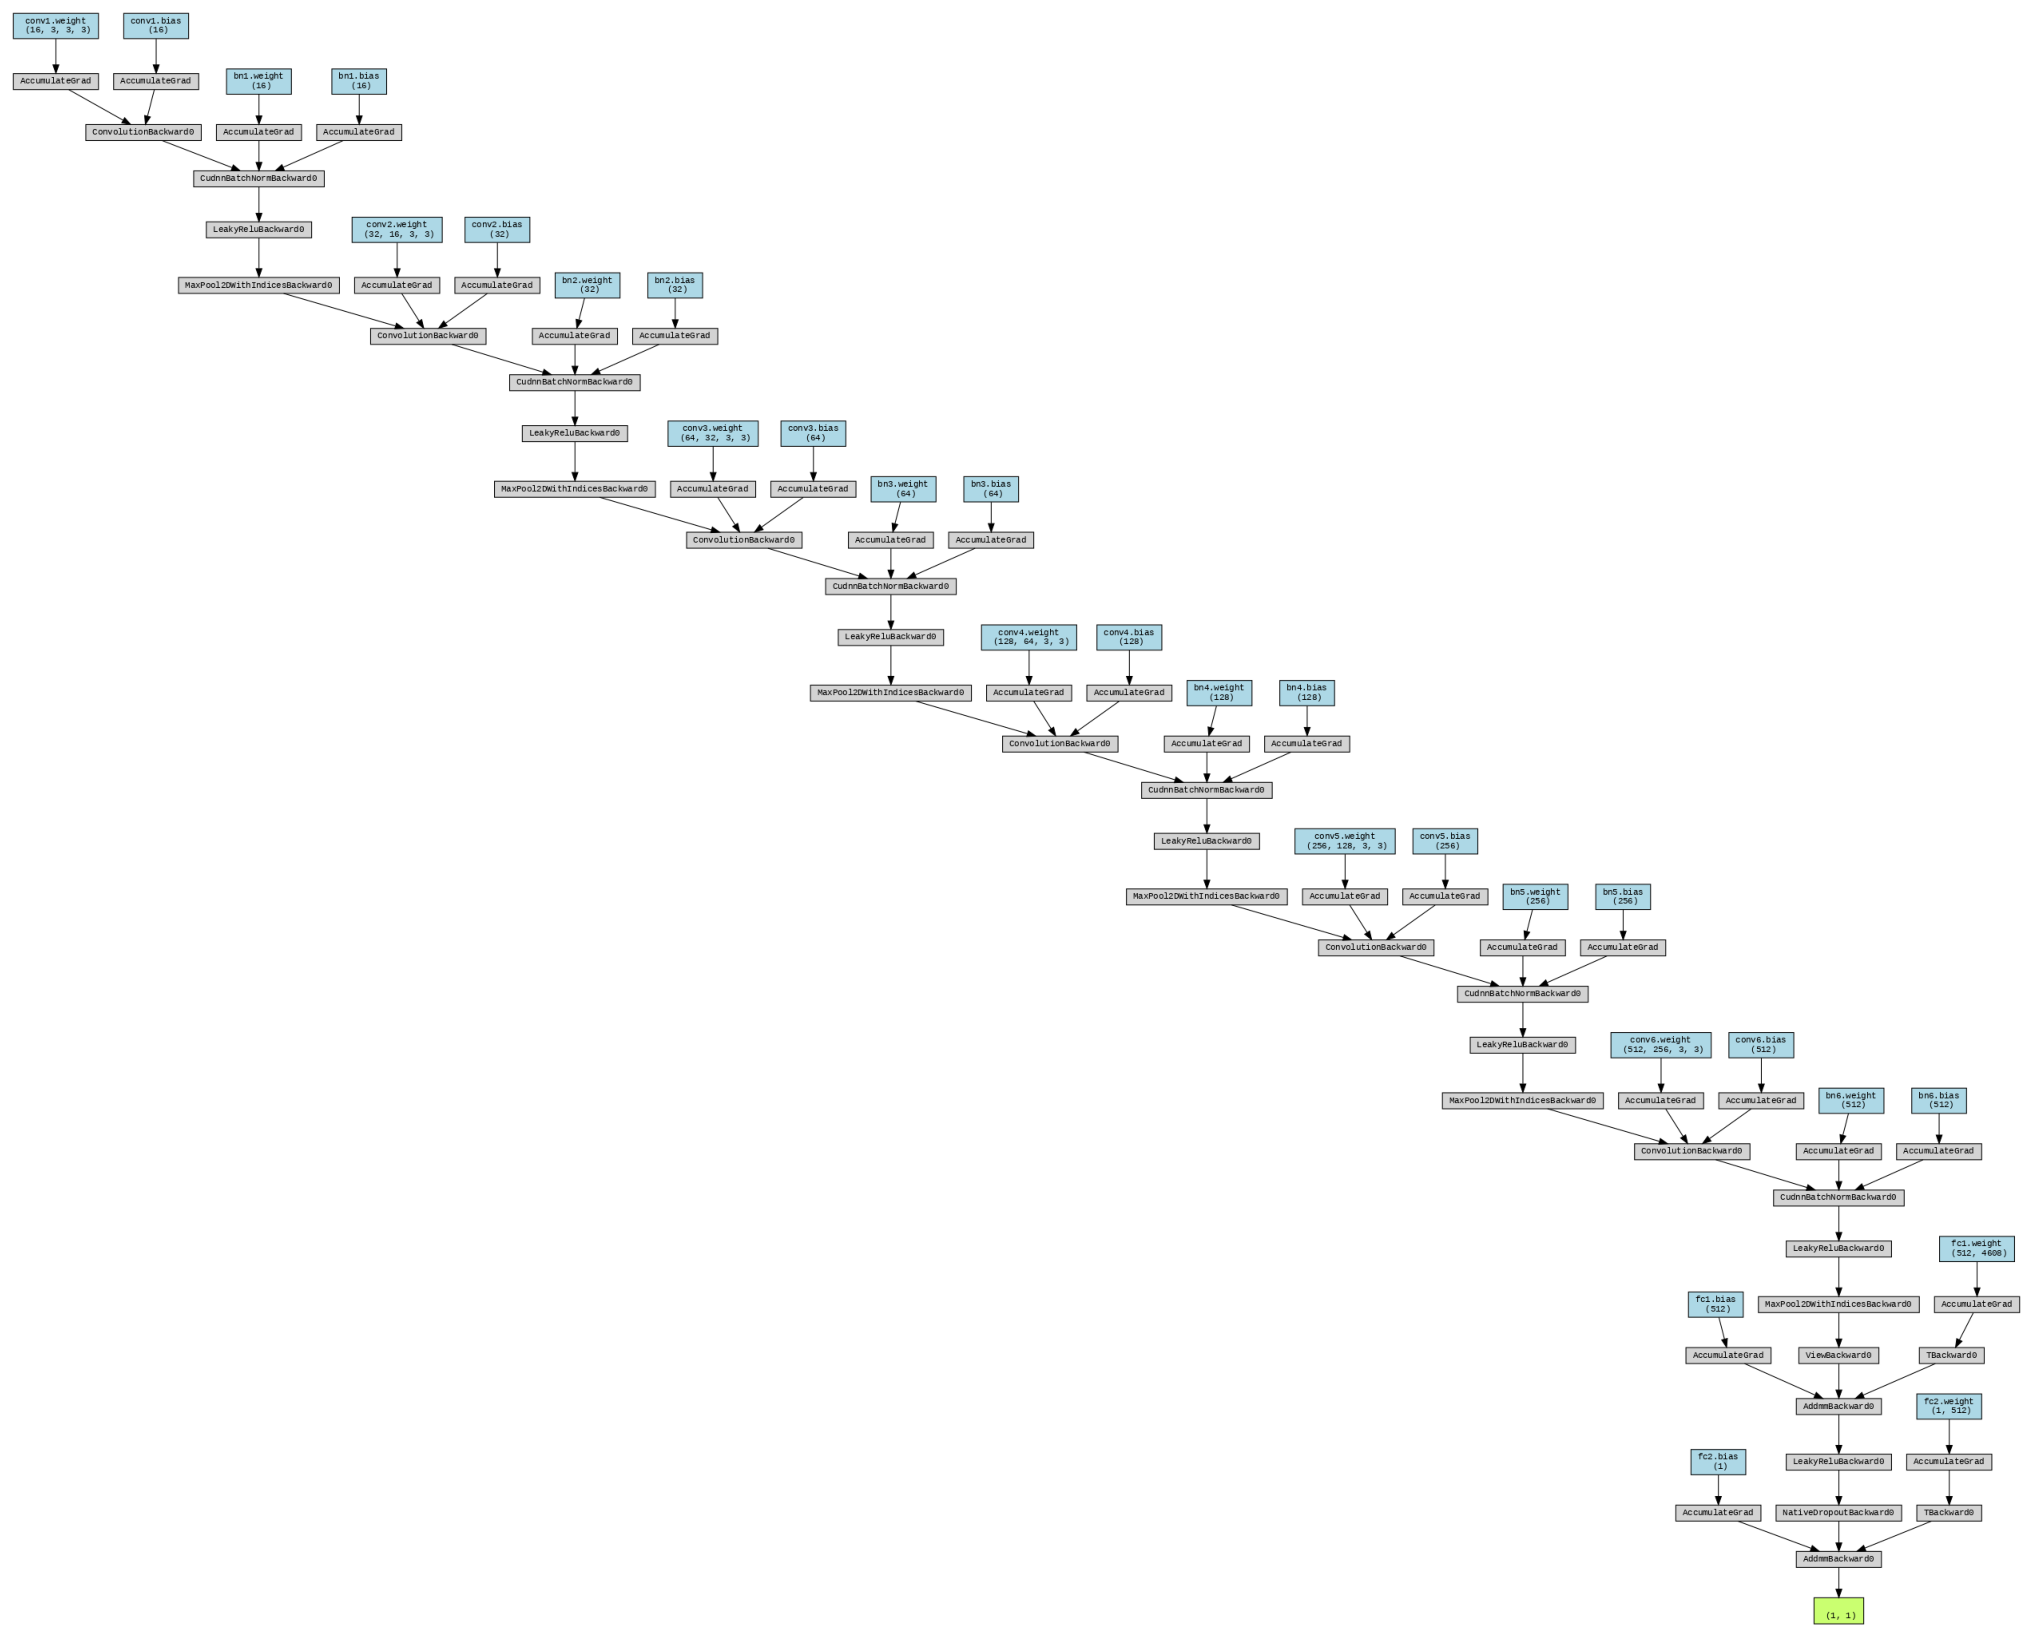

In [74]:
# Display the image using matplotlib
img = mpimg.imread("/content/cnn_architecture3 for skincancer.png")
plt.figure(figsize=(35, 21))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

#Training Phase

In [75]:
num_epoch = 25
loss_fn = nn.BCEWithLogitsLoss()
lr=0.001
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [76]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)


In [77]:
train_loss_list=[]
val_loss_list=[]
acc_list=[]

best_val_loss = float('inf')  # Initialize the best validation loss
best_model_wts = None  # Variable to hold the best model weights

In [78]:
for epoch in range(num_epoch):
    train_loss = 0
    val_loss = 0
    total = 0
    correct = 0

    # Training phase
    Model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1).float()  # Ensure labels are float

        # Forward pass
        outputs = Model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation phase
    Model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1).float()  # Ensure labels are float

            outputs = Model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Get probabilities and predictions
            probabilities = torch.sigmoid(outputs)  # Apply sigmoid for evaluation
            predicted = (probabilities > 0.5).float()  # Thresholding at 0.5

            total += len(labels)
            correct += (predicted == labels).sum().item()

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Calculate performance of training model
    accuracy = 100 * correct / float(total)
    train_loss_list.append(train_loss / len(train_loader))
    val_loss_list.append(val_loss / len(val_loader))
    acc_list.append(accuracy)

    print('-' * 100)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epoch + 1, num_epoch, train_loss / len(train_loader), val_loss / len(val_loader), accuracy))

    # Check if the current validation loss is the best we've seen so far
    avg_val_loss = val_loss / len(val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = Model.state_dict()
        print("Best model weights saved.")

    # Check for early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping at epoch:", epoch + 1)
        break

# Save the best model weights to a file
if best_model_wts is not None:
    torch.save(best_model_wts, 'best_model_weights.pth')
    print("Best model weights saved to 'best_model_weights.pth'.")

----------------------------------------------------------------------------------------------------
Epoch [1/25], Train Loss: 0.7374, Val Loss: 0.5794, Accuracy: 67.50%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [2/25], Train Loss: 0.5276, Val Loss: 0.4649, Accuracy: 76.11%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [3/25], Train Loss: 0.5161, Val Loss: 0.4521, Accuracy: 79.72%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [4/25], Train Loss: 0.5244, Val Loss: 0.4820, Accuracy: 76.67%
----------------------------------------------------------------------------------------------------
Epoch [5/25], Train Loss: 0.4829, Val Loss: 0.4383, Accuracy: 80.28%
Best model weights saved.
----------------------------------------------

In [79]:
print(f'Number of epochs: {num_epoch}')
print(f'Train Loss List Length: {len(train_loss_list)}')
print(f'Validation Loss List Length: {len(val_loss_list)}')
print(f'Accuracy List Length: {len(acc_list)}')


Number of epochs: 25
Train Loss List Length: 21
Validation Loss List Length: 21
Accuracy List Length: 21


In [83]:
num_epoch = 21

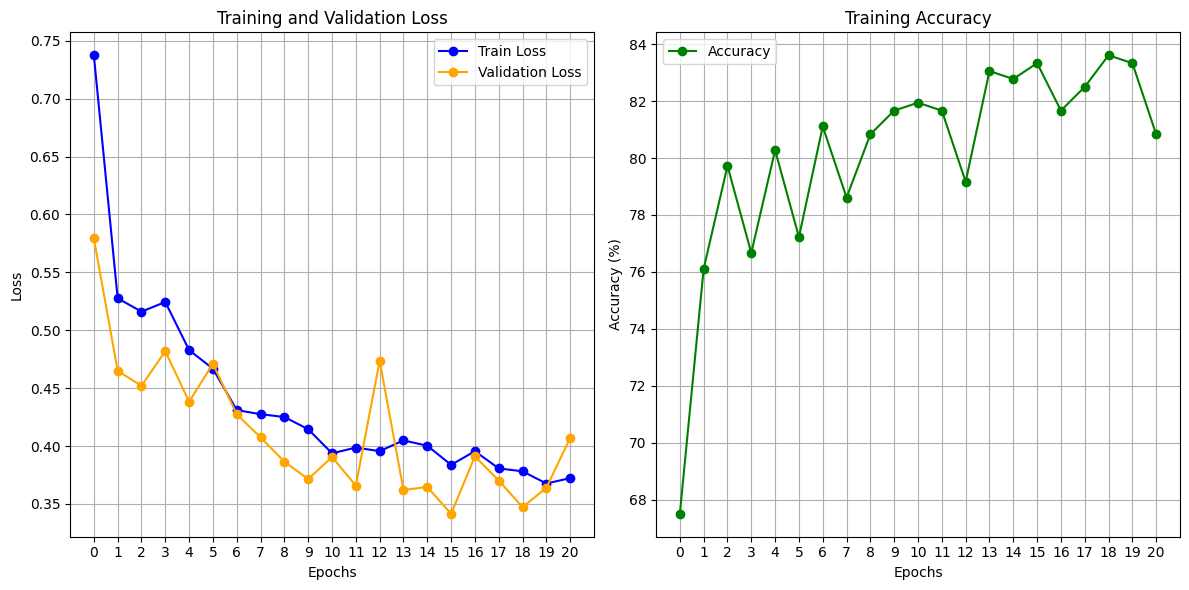

In [84]:


# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(range(num_epoch), train_loss_list, label='Train Loss', color='blue', marker='o')
plt.plot(range(num_epoch), val_loss_list, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(num_epoch))  # Ensure all epochs are labeled
plt.grid(True)
plt.legend()
plt.tight_layout()

# Accuracy Plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(range(num_epoch), acc_list, label='Accuracy', color='green', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(num_epoch))  # Ensure all epochs are labeled
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plots
plt.show()


#Evaluation

Test Loss: 0.4214, Test Accuracy: 80.83%
Precision: 0.73, Recall: 0.97, F1 Score: 0.84, ROC AUC: 0.81


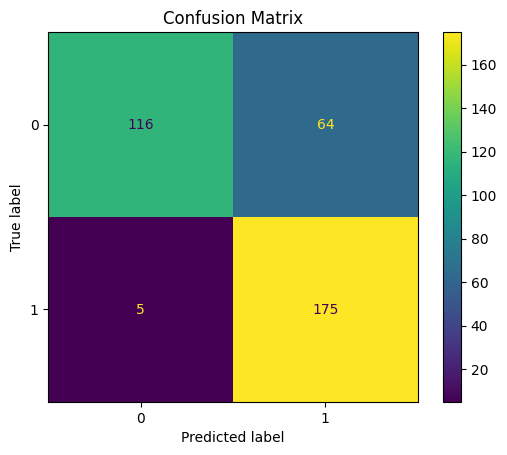

In [95]:
# Test phase
Model.eval()  # Set model to evaluation mode

# Initialize lists to store metrics
test_loss = 0
total = 0
correct = 0
all_test_labels = []
all_test_predictions = []
test_loss_list = []  # List to store all test losses
test_accuracy_list = []  # List to store test accuracy for each epoch

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1).float()  # Ensure labels are float

        # Forward pass
        outputs = Model(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        # Append individual loss to the list for visualization
        test_loss_list.append(loss.item())  # Store each loss

        # Collecting true and predicted labels
        probabilities = torch.sigmoid(outputs)  # Apply sigmoid for evaluation
        predicted = (probabilities > 0.5).float()  # Thresholding at 0.5
        total += len(labels)
        correct += (predicted == labels).sum().item()

        # Store labels and predictions for metrics
        all_test_labels.extend(labels.cpu().numpy())  # Collect true labels
        all_test_predictions.extend(predicted.cpu().numpy())  # Collect predicted labels

# Calculate average test loss and accuracy
test_loss_avg = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

# Append the accuracy for the current epoch
test_accuracy_list.append(test_accuracy)

# Calculate additional metrics
precision = precision_score(all_test_labels, all_test_predictions)
recall = recall_score(all_test_labels, all_test_predictions)
f1 = f1_score(all_test_labels, all_test_predictions)
roc_auc = roc_auc_score(all_test_labels, all_test_predictions)

# Print test results
print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}')

# Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


###test phase explain:

It sets the model to evaluation mode, which ensures that certain layers, like dropout and batch normalization, behave appropriately during testing. Several variables are initialized to store metrics such as total loss, the number of samples processed, and the number of correct predictions. Lists are also created to hold true and predicted labels for later analysis.

The code then enters a context where gradient calculations are disabled to save memory and speed up computations during inference. It iterates over batches of images and labels from the test dataset. Each batch is transferred to the specified device (like a GPU), and the labels are reshaped to match the model's output requirements.

During the forward pass, the input images are fed through the model to generate predictions. The loss is calculated using a predefined loss function and accumulated over all batches. The model's outputs undergo a sigmoid activation to convert them into probabilities, which are then thresholded at 0.5 to get binary predictions.

The total number of samples and the count of correct predictions are updated accordingly. True and predicted labels are collected for further metrics calculation.

After processing all batches, the average test loss and accuracy are computed. Additional metrics such as precision, recall, F1 score, and ROC AUC are calculated using the collected true and predicted labels.

Finally, the results are printed, displaying the average test loss, accuracy, and other metrics formatted for clarity. The code also computes the confusion matrix to visualize the model's performance, creating and displaying a plot of the confusion matrix to help interpret the results.

This entire process effectively evaluates the model's performance on the test dataset, providing valuable insights into its accuracy and reliability.

In [98]:
print(f'Number of epochs: {num_epoch}')
print(f'test Loss List Length: {len(test_loss_list)}')
print(f'test accuracy List Length: {len(test_accuracy_list)}')


Number of epochs: 21
test Loss List Length: 12
test accuracy List Length: 1


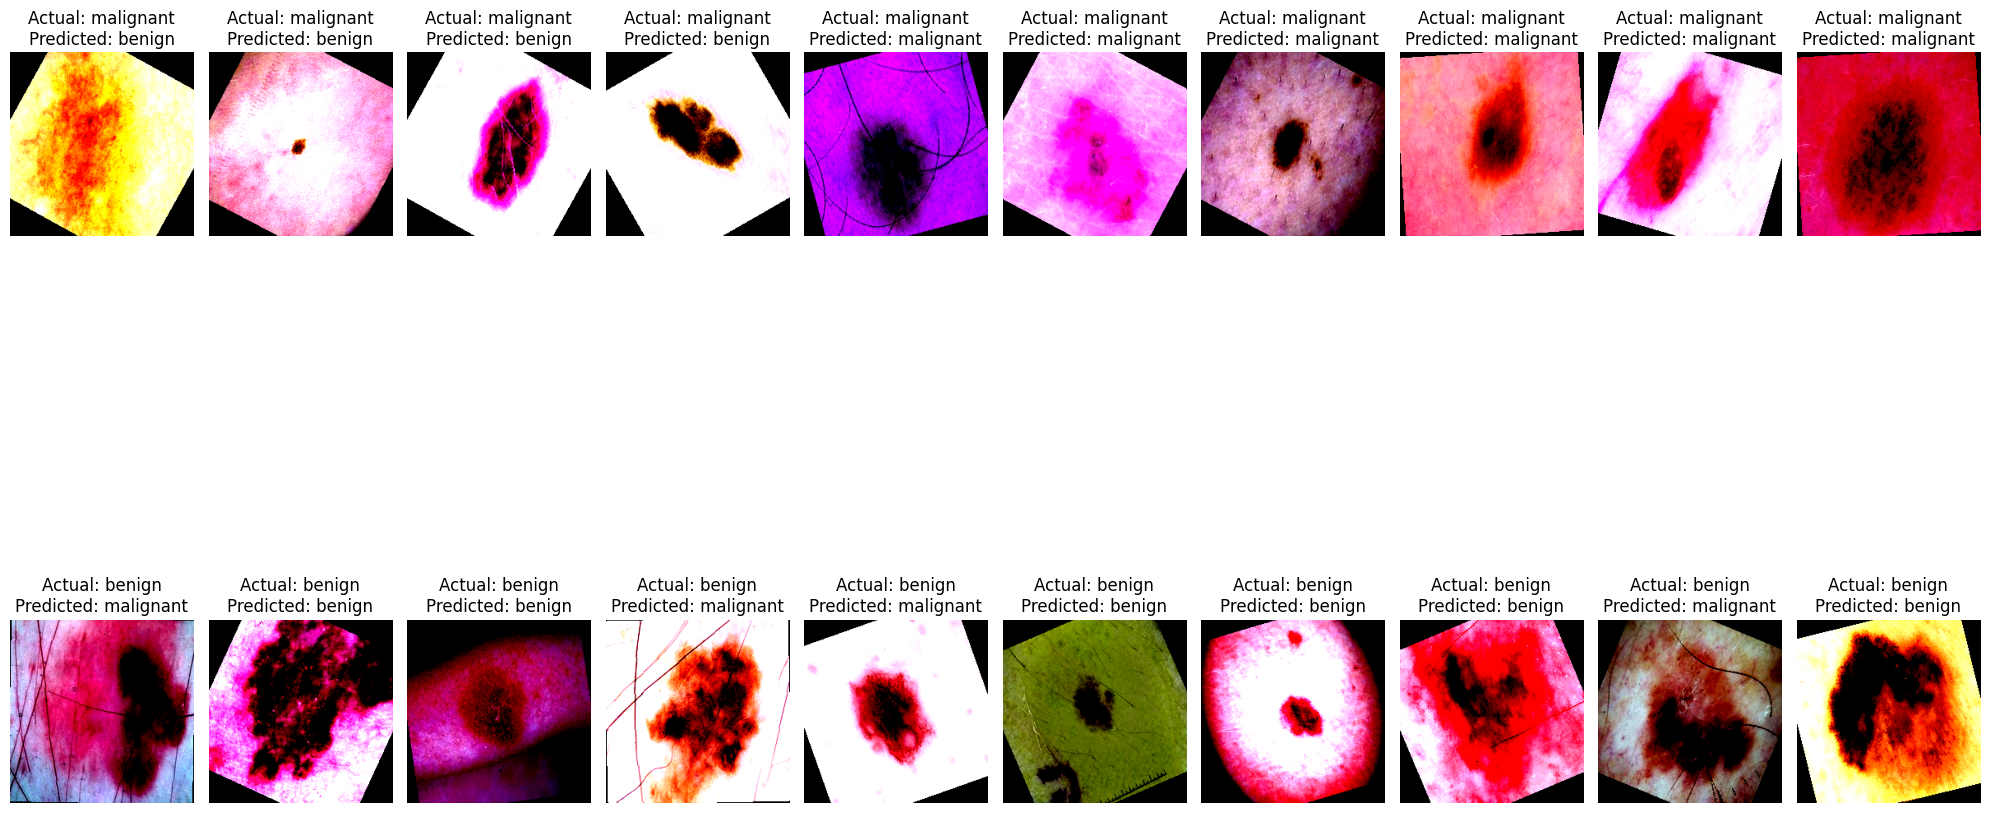

In [99]:
import random
import matplotlib.pyplot as plt
import torch

def visualize_predictions1(model, test_set, num_samples=10, class_names=None):
    # Set model to evaluation mode
    model.eval()

    # If class_names are not provided, get them from the dataset
    if class_names is None:
        class_names = test_set.dataset.classes  # Access the original dataset's classes

    # Create a figure to hold the plots
    plt.figure(figsize=(20, 15))

    # Initialize a list to keep track of samples chosen
    chosen_indices = []

    # Loop through each class
    for class_idx in range(len(class_names)):
        # Get all indices of the current class
        class_indices = [i for i, (_, label) in enumerate(test_set) if label == class_idx]

        # Randomly select num_samples indices from the class indices
        selected_indices = random.sample(class_indices, num_samples)
        chosen_indices.extend(selected_indices)

        # Loop through the selected indices and plot the images
        for i, idx in enumerate(selected_indices):
            img, label = test_set[idx]
            img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device

            # Generate a random prediction
            random_pred = random.choice(range(len(class_names)))

            # Plot the image
            plt.subplot(len(class_names), num_samples, class_idx * num_samples + i + 1)
            plt.imshow(img.cpu().squeeze(0).permute(1, 2, 0))  # Convert to HWC format
            plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[random_pred]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'test_dataset' is a Subset of a larger dataset
# You can call the function like this:
visualize_predictions1(Model, test_dataset)


#Pre trained model

In [124]:
# Define the number of classes
num_classes = 2

# Define the models
models_dict = {
    'densenet': models.densenet121(weights='DEFAULT'),
    'resnet': models.resnet50(weights='DEFAULT'),
    'inception': models.inception_v3(weights='DEFAULT', aux_logits=True),
    'vgg': models.vgg16(weights='DEFAULT'),
}

In [125]:
import torch.nn as nn
from torchvision import models

def modify_final_layer(model, num_classes):
    if isinstance(model, models.ResNet):
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 128),  # First FC layer
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Second FC layer
        )
    elif isinstance(model, models.DenseNet):
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier.in_features, 128),  # First FC layer
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Second FC layer
        )
    elif isinstance(model, models.VGG):
        model.classifier[-1] = nn.Sequential(
            nn.Linear(model.classifier[-1].in_features, 128),  # First FC layer
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Second FC layer
        )
    elif isinstance(model, models.Inception3):
        model.AuxLogits.fc = nn.Sequential(
            nn.Linear(model.AuxLogits.fc.in_features, 128),  # First FC layer
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Second FC layer
        )
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 128),  # First FC layer
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Second FC layer
        )
    else:
        raise Exception(f"Unsupported model type: {type(model).__name__}")

# Modify the final layers of all models
for name, model in models_dict.items():
    print(f"Model: {name}")
    modify_final_layer(model, num_classes)
    print(model)  # Print the model structure


Model: densenet
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [126]:
# Function to visualize the model
def visualize_model(model, model_name):
    dummy_input = torch.randn(1, 3, 224, 224)
    dot = make_dot(model(dummy_input), params=dict(list(model.named_parameters())))
    dot.render(os.path.join(output_dir, model_name), format='png', cleanup=True)

# Visualize each model and save the images
for name, model in models_dict.items():
    visualize_model(model, name)

# Plot the saved images using matplotlib
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

for i, model_name in enumerate(models_dict.keys()):
    img_path = os.path.join(output_dir, f"{model_name}.png")
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(model_name)

plt.tight_layout()
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.921846 to fit


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [127]:

# Define the transformations
transform_dict = {
    'inception': transforms.Compose([
        transforms.Resize((299, 299)),  # Resize for Inception V3
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(p=0.5),  # Randomly flip images vertically
        transforms.RandomRotation(degrees=30),  # Randomly rotate images
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ]),
    'default': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(p=0.5),  # Randomly flip images vertically
        transforms.RandomRotation(degrees=30),  # Randomly rotate images
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ]),
}




In [128]:
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Training function
def train_model(model, train_loader, val_loader, num_epochs=4, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
        print('-'*100)



In [129]:
# Train each model
for name, model in models_dict.items():
    print(f"Training model: {name}")
    print('='*100)

    if name == 'inception':
        # Use the specific transformations and dataset for Inception
        train_dataset = CustomDataset(df_resampled, transform=transform_dict['inception'])
        val_dataset = CustomDataset(df_resampled, transform=transform_dict['inception'])
    else:
        # Use default transformations for other models
        train_dataset = CustomDataset(df_resampled, transform=transform_dict['default'])
        val_dataset = CustomDataset(df_resampled, transform=transform_dict['default'])

    # Create data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

    # Train the model
    train_model(model, train_loader, val_loader)


Training model: densenet


OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 25.06 MiB is free. Process 4763 has 14.72 GiB memory in use. Of the allocated memory 14.18 GiB is allocated by PyTorch, and 418.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#pre trained model evaluation

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Define the test phase function
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode

    # Initialize lists to store metrics
    test_loss = 0
    total = 0
    correct = 0
    all_test_labels = []
    all_test_predictions = []
    test_loss_list = []

    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            test_loss += loss.item()
            test_loss_list.append(loss.item())  # Store each loss

            # Collecting true and predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store labels and predictions for metrics
            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())

    # Calculate average test loss and accuracy
    test_loss_avg = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    # Calculate additional metrics
    precision = precision_score(all_test_labels, all_test_predictions, average='weighted')
    recall = recall_score(all_test_labels, all_test_predictions, average='weighted')
    f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')
    roc_auc = roc_auc_score(all_test_labels, all_test_predictions, multi_class='ovr')

    # Print test results
    print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}')

    # Confusion Matrix
    cm = confusion_matrix(all_test_labels, all_test_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    # Optional: Plotting the test loss over batches
    plt.figure(figsize=(10, 5))
    plt.plot(test_loss_list, label='Test Loss')
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title(f'Test Loss over Batches for {model.__class__.__name__}')
    plt.legend()
    plt.show()

# Test each model
for name, model in models_dict.items():
    print(f"Testing model: {name}")
    print('='*100)

    # Use the same transformations for the test dataset
    if name == 'inception':
        test_dataset = CustomDataset(df_test, transform=transform_dict['inception'])
    else:
        test_dataset = CustomDataset(df_test, transform=transform_dict['default'])

    # Create data loader for testing
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

    # Test the model
    test_model(model, test_loader)
